In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import join
import re
from os import makedirs
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import display
import seaborn as sns
from time import time

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")
output_plots_dir = join("output_plots")
makedirs(output_plots_dir, exist_ok=True)

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output
from analysis_of_embeddings.estimate_num_meanings_supervised import (
    create_classification_labels,
    evaluate_regression_model,
    evaluate_classification_model,
    create_feature_importance_df,
    visualize_feature_importances,
)
from analysis_utils import word_group_visualization
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


[nltk_data] Downloading package punkt to /project/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<IPython.core.display.Javascript object>

## Prepare data

In [3]:
def format_feature_name_human_readable(feature_name: str) -> str:
    """
    Formats feature names to make them human readable (e.g. for thesis).

    Parameters
    ----------
    feature_name : str
        Feature name to make human readable.

    Returns
    -------
    human_readable_feature_name : str
        Human readable feature name.
    """
    alg_names = ["tps", "gad", "estimated_id"]
    human_readable_regexes = [
        r"X_tps_(\d+)(_pd_(?:max|avg|std)|)",
        r"X_gad_knn_(\d+)_(\d+)_(P_man|P_bnd|P_int)",
        r"X_estimated_id_(.+)_(\d+)",
    ]
    for alg_name, human_readable_re in zip(alg_names, human_readable_regexes):
        re_match = re.match(human_readable_re, feature_name)
        if re_match is None:
            continue
        re_groups = re_match.groups()
        if alg_name == "tps":
            tps_n = re_groups[0]
            if re_groups[1] is None:
                return fr"TPS$_{tps_n}"
            else:
                tps_pd_type = re_groups[1]
                return fr"TPS{tps_pd_type}_{tps_n}"
        elif alg_name == "gad":
            inner_annulus_knn, outer_annulus_knn, P_cat = re_groups
            P_cat_human = {
                "P_man": "manifold",
                "P_bnd": "boundary",
                "P_int": "singular",
            }
            return fr"GAD_{P_cat_human[P_cat]}_{inner_annulus_knn}_{outer_annulus_knn}"
        elif alg_name == "estimated_id":
            id_estimator_name, num_neighbours = re_groups
            id_estimator_human = {
                "lpca": "LPCA",
                "knn": "KNN",
                "twonn": "TWO-NN",
                "mle": "MLE",
                "tle": "TLE",
            }
            return fr"ID_{id_estimator_human[id_estimator_name]}_{num_neighbours}"

<IPython.core.display.Javascript object>

In [4]:
word_meaning_train_data = pd.read_csv("data/word_meaning_train_data.csv")
word_meaning_test_data = pd.read_csv("data/word_meaning_test_data.csv")
word_meaning_semeval_test_data = pd.read_csv("data/word_meaning_semeval_test_data.csv")
word_meaning_data_cols = word_meaning_train_data.columns.values
word_meaning_data_feature_cols = np.array(
    [col for col in word_meaning_data_cols if col.startswith("X_")]
)
word_meaning_data_feature_cols_human_readable = np.array(
    [format_feature_name_human_readable(col) for col in word_meaning_data_feature_cols]
)

<IPython.core.display.Javascript object>

In [5]:
print("Train")
word_meaning_train_data

Train


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_200_1250_P_bnd,X_gad_knn_200_1500_P_man,X_gad_knn_200_1500_P_int,X_gad_knn_200_1500_P_bnd,X_gad_knn_200_1750_P_man,X_gad_knn_200_1750_P_int,X_gad_knn_200_1750_P_bnd,X_gad_knn_200_2000_P_man,X_gad_knn_200_2000_P_int,X_gad_knn_200_2000_P_bnd
0,wheatgrass,1,3.338852,0.905638,0.741967,0.081652,6.572863,0.905638,0.691880,0.099576,...,1,0,0,1,0,0,1,0,0,1
1,breeder_reactor,1,3.640951,0.930674,0.809100,0.062551,7.521767,0.889904,0.791765,0.040636,...,1,0,0,1,0,0,1,0,0,1
2,george_orwell,1,3.831224,0.980266,0.851383,0.094995,7.626404,0.996299,0.802779,0.103484,...,1,0,0,1,0,0,1,0,0,1
3,allergic_reaction,1,3.512495,0.919761,0.780554,0.074057,7.200166,0.944749,0.757912,0.082481,...,1,0,0,1,0,0,1,0,0,1
4,eruditely,1,4.089242,0.971101,0.908721,0.042953,8.363533,0.959047,0.880372,0.029349,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137093,cowpunchers,1,4.156156,1.009153,0.923590,0.067484,8.243649,0.963421,0.867753,0.061893,...,1,0,0,1,0,0,1,0,0,1
137094,pneumatic_caisson,1,4.213827,1.033439,0.936406,0.047094,8.371931,0.960133,0.881256,0.041919,...,1,0,0,1,0,0,1,0,0,1
137095,niobite,1,3.803122,1.009288,0.845138,0.089276,8.007638,1.009985,0.842909,0.073760,...,0,0,1,0,0,1,0,0,1,0
137096,spruced_up,1,3.213259,0.920850,0.714057,0.127273,6.647033,0.931353,0.699688,0.109437,...,1,0,0,1,0,0,1,0,0,1


<IPython.core.display.Javascript object>

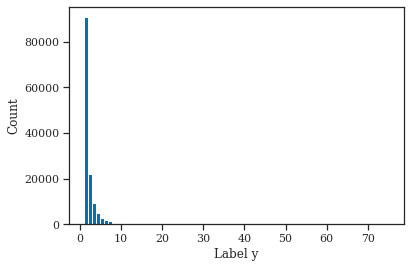

<IPython.core.display.Javascript object>

In [6]:
plt.hist(word_meaning_train_data["y"], bins=word_meaning_train_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [7]:
print("Test")
word_meaning_test_data

Test


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_200_1250_P_bnd,X_gad_knn_200_1500_P_man,X_gad_knn_200_1500_P_int,X_gad_knn_200_1500_P_bnd,X_gad_knn_200_1750_P_man,X_gad_knn_200_1750_P_int,X_gad_knn_200_1750_P_bnd,X_gad_knn_200_2000_P_man,X_gad_knn_200_2000_P_int,X_gad_knn_200_2000_P_bnd
0,millinery,2,4.113964,1.025418,0.914214,0.074536,7.941398,1.005300,0.835937,0.109570,...,1,0,0,1,0,0,1,0,0,1
1,delegates,3,4.421070,1.123658,0.982460,0.090000,8.802174,1.097448,0.926545,0.124209,...,1,0,0,1,0,0,1,0,0,1
2,mutely,1,3.997394,0.958832,0.888310,0.042170,8.076848,0.976295,0.850195,0.060368,...,0,1,0,0,1,0,0,1,0,0
3,overseas,4,4.709002,1.157293,1.046445,0.078913,9.061800,1.103109,0.953874,0.083135,...,1,0,0,1,0,0,1,0,0,1
4,lanceolate_leaves,1,4.229253,0.994342,0.939834,0.043271,8.449794,1.006421,0.889452,0.065294,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,verbal_noun,1,3.631712,0.895475,0.807047,0.060252,7.756122,1.009369,0.816434,0.080999,...,0,1,0,0,1,0,0,1,0,0
7212,greenwings,1,3.963176,1.029086,0.880706,0.078426,7.775979,0.955795,0.818524,0.078575,...,1,0,0,1,0,0,1,0,0,1
7213,azeris,1,4.511842,1.135311,1.002632,0.090496,8.474615,1.049158,0.892065,0.095074,...,1,0,0,1,0,0,1,0,0,1
7214,northwester,3,3.716126,0.856231,0.825806,0.025421,7.629259,0.892538,0.803080,0.037137,...,0,0,1,0,0,1,0,0,1,0


<IPython.core.display.Javascript object>

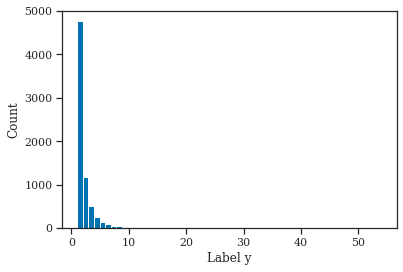

<IPython.core.display.Javascript object>

In [8]:
plt.hist(word_meaning_test_data["y"], bins=word_meaning_test_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [9]:
# Split into X and y
data_scaler = StandardScaler()
data_scaler.fit(word_meaning_train_data[word_meaning_data_feature_cols].values)
X_train = data_scaler.transform(
    word_meaning_train_data[word_meaning_data_feature_cols].values
)
X_test = data_scaler.transform(
    word_meaning_test_data[word_meaning_data_feature_cols].values
)
X_test_semeval = data_scaler.transform(
    word_meaning_semeval_test_data[word_meaning_data_feature_cols].values
)
y_train = word_meaning_train_data["y"].values
y_test = word_meaning_test_data["y"].values
y_test_semeval = word_meaning_semeval_test_data["y"].values

<IPython.core.display.Javascript object>

In [10]:
# Create multi-class labels
max_y_multi = np.quantile(y_train, q=0.9)
y_train_binary_classes = create_classification_labels(labels=y_train, max_label=1)
y_train_multi_class = create_classification_labels(
    labels=y_train, max_label=max_y_multi
)
y_test_binary_classes = create_classification_labels(labels=y_test, max_label=1)
y_test_multi_class = create_classification_labels(labels=y_test, max_label=max_y_multi)
y_test_semeval_binary_classes = create_classification_labels(
    labels=y_test_semeval, max_label=1
)
y_test_semeval_multi_class = create_classification_labels(
    labels=y_test_semeval, max_label=max_y_multi
)
labels_str = [
    str(label + 1) if i < 4 else "gt_or_eq_5"
    for i, label in enumerate(np.unique(y_train_multi_class))
]

<IPython.core.display.Javascript object>

In [11]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [12]:
# Load SemEval-2010 task 14 words
semeval_2010_14_word_senses = joblib.load(
    join(
        "..", "topological_data_analysis", "data", "semeval_2010_14_word_senses.joblib"
    )
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_target_words_in_vocab)

<IPython.core.display.Javascript object>

## Evaluate modeling results

In [13]:
# Constants
estimate_num_meanings_supervised_dir = join("data", "estimate_num_meanings_supervised")

<IPython.core.display.Javascript object>

### LASSO / Logistic regression

#### LASSO

In [14]:
# Load results
lasso_reg = joblib.load(join(estimate_num_meanings_supervised_dir, "lasso_reg.joblib"))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator LassoCV from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.



<IPython.core.display.Javascript object>

In [15]:
print(f"Selected alpha: {lasso_reg.alpha_:.16f}")

Selected alpha: 0.0000291026102610


<IPython.core.display.Javascript object>

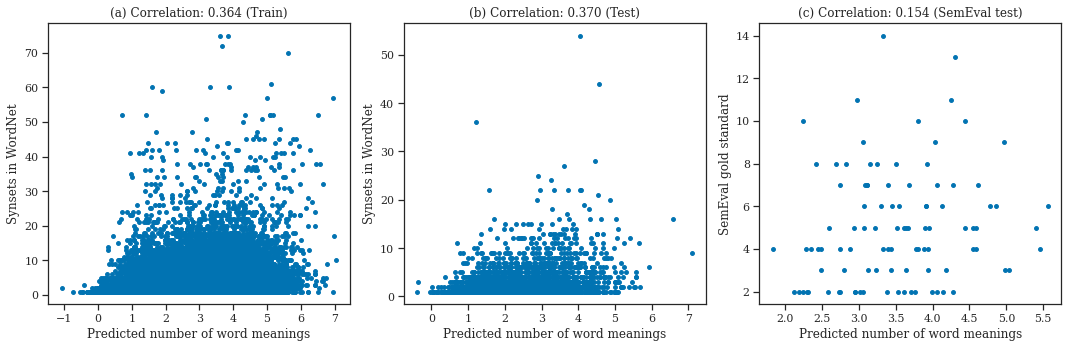

<IPython.core.display.Javascript object>

In [16]:
# LASSO regression
evaluate_regression_model(
    model=lasso_reg,
    test_sets=[
        (
            X_train,
            y_train,
            "Train",
            "Predicted number of word meanings",
            "Synsets in WordNet",
        ),
        (
            X_test,
            y_test,
            "Test",
            "Predicted number of word meanings",
            "Synsets in WordNet",
        ),
        (
            X_test_semeval,
            y_test_semeval,
            "SemEval test",
            "Predicted number of word meanings",
            "SemEval gold standard",
        ),
    ],
    show_plot=False,
    use_rasterization=True,
)

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "wme-enwiki-correlation-result.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

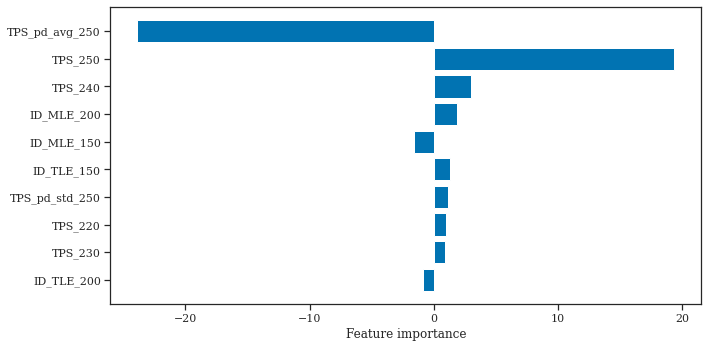

<IPython.core.display.Javascript object>

In [17]:
# Visualize top 10 feature importances
_, ax = plt.subplots(figsize=(10, 5))

# Sort coefficient by absolute value
lasso_reg_coef_abs_sorted_indces = np.argsort(abs(lasso_reg.coef_))[::-1]
top_n_importances = 10
top_n_importances_indices = lasso_reg_coef_abs_sorted_indces[:top_n_importances]

# Plot horizontal barplot
y_pos = np.arange(top_n_importances)
ax.barh(y=y_pos, width=lasso_reg.coef_[top_n_importances_indices], color="b")
ax.set_yticks(y_pos)
ax.set_yticklabels(
    word_meaning_data_feature_cols_human_readable[top_n_importances_indices]
)
ax.invert_yaxis()
ax.set_xlabel("Feature importance")

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "wme-enwiki-top-10-feature-importances.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

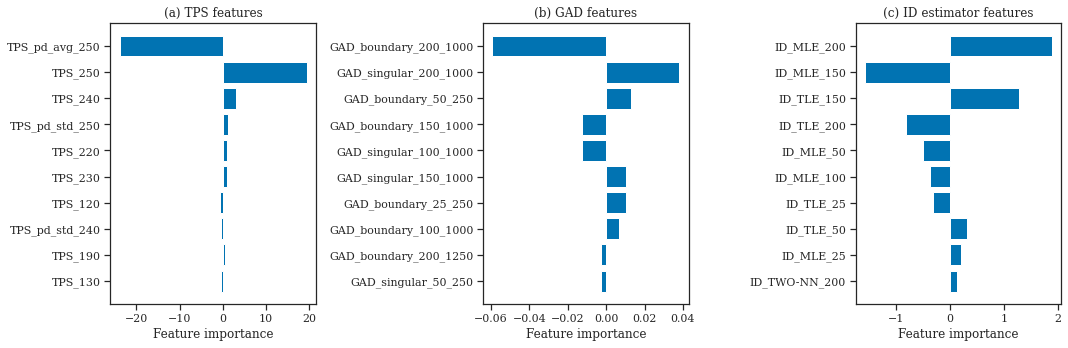

<IPython.core.display.Javascript object>

In [18]:
# Visualize top 10 feature importances
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax_chars = "abc"

top_n_importances = 10
feature_alg_names = ["TPS", "GAD", "ID estimator"]
feature_alg_names_start = ["X_tps", "X_gad", "X_estimated_id"]
for ax, ax_char, alg_name, alg_names_start in zip(
    axes, ax_chars, feature_alg_names, feature_alg_names_start
):
    # Filter algorithm columns
    alg_filter = [
        i
        for i, feature_col in enumerate(word_meaning_data_feature_cols)
        if feature_col.startswith(alg_names_start)
    ]
    alg_coeffs = lasso_reg.coef_[alg_filter]

    # Sort coefficient by absolute value
    lasso_reg_coef_abs_sorted_indces = np.argsort(abs(alg_coeffs))[::-1]
    top_n_importances_indices = lasso_reg_coef_abs_sorted_indces[:top_n_importances]

    # Plot horizontal barplot
    y_pos = np.arange(top_n_importances)
    ax.barh(y=y_pos, width=alg_coeffs[top_n_importances_indices], color="b")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(
        word_meaning_data_feature_cols_human_readable[alg_filter][
            top_n_importances_indices
        ]
    )
    ax.invert_yaxis()
    ax.set_xlabel("Feature importance")
    ax.set_title(f"({ax_char}) {alg_name} features")

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "wme-enwiki-top-10-feature-importances-tps-gad-estimated-ids.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

In [19]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=np.abs(lasso_reg.coef_),
    )
)

,feature,importance
0,X_tps_250_pd_avg,23.886318963019136
1,X_tps_250,19.401101910761067
2,X_tps_240,3.0168256989026534
3,X_estimated_id_mle_200,1.890739043927234
4,X_estimated_id_mle_150,1.5828772842164265
5,X_estimated_id_tle_150,1.2816947145100372
6,X_tps_250_pd_std,1.1717667967519212
7,X_tps_220,0.9624246174948632
8,X_tps_230,0.9041989965094909
9,X_estimated_id_tle_200,0.823485163176394


<IPython.core.display.Javascript object>

In [20]:
print(f"Number of zero features: {sum(lasso_reg.coef_ == 0)}")

Number of zero features: 48


<IPython.core.display.Javascript object>

#### Logistic regression with L1 penalty

In [21]:
# Load results
binary_logistic_reg = joblib.load(
    join(estimate_num_meanings_supervised_dir, "binary_logistic_reg.joblib")
)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator LogisticRegressionCV from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.



<IPython.core.display.Javascript object>

In [22]:
print(f"Selected alpha: {(1 / binary_logistic_reg.C_[0]):.16f}")

Selected alpha: 0.0006923852385239


<IPython.core.display.Javascript object>

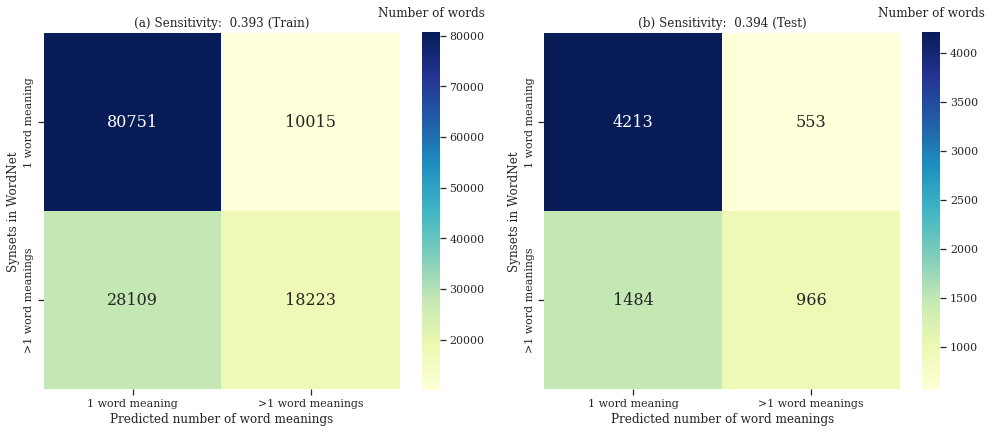

<IPython.core.display.Javascript object>

In [23]:
# Binary classification
evaluate_classification_model(
    model=binary_logistic_reg,
    test_sets=[
        (
            X_train,
            y_train_binary_classes,
            "Train",
            "Predicted number of word meanings",
            "Synsets in WordNet",
        ),
        (
            X_test,
            y_test_binary_classes,
            "Test",
            "Predicted number of word meanings",
            "Synsets in WordNet",
        ),
    ],
    cm_ticklabels=["1 word meaning", ">1 word meanings"],
    show_plot=False,
)

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "bwme-enwiki-confusion-matrices.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

In [32]:
# Report examples of misclassified polysemous words from BWME-enwiki model
polysemous_test_indices = np.where(y_test_binary_classes == 1)[0]
polysemous_test_true_values = y_test_binary_classes[polysemous_test_indices]
polysemous_test_pred_values = binary_logistic_reg.predict(
    X_test[polysemous_test_indices]
)
misclassified_test_word_indices = []
for poly_idx, true_val, pred_val in zip(
    polysemous_test_indices, polysemous_test_true_values, polysemous_test_pred_values
):
    word = word_meaning_test_data.iloc[poly_idx]["word"]
    if pred_val != true_val:
        misclassified_test_word_indices.append(poly_idx)

# Sort misclassified classified polysemous test words
misclassified_test_word_indices = np.array(misclassified_test_word_indices)
misclassified_test_words = word_meaning_test_data.iloc[misclassified_test_word_indices][
    "word"
].values
misclassified_test_words_word_count_sorted_indices = np.argsort(
    [word_to_int[word] for word in misclassified_test_words]
)
misclassified_test_words_sorted = misclassified_test_words[
    misclassified_test_words_word_count_sorted_indices
]

<IPython.core.display.Javascript object>

In [33]:
print("Misclassified polysemous words from BWME-enwiki model:")
for i in range(10):
    print(f"- {misclassified_test_words_sorted[i]}")

Misclassified polysemous words from BWME-enwiki model:
- time
- age
- returned
- italian
- chicago
- gold
- tower
- jones
- unable
- opposition


<IPython.core.display.Javascript object>

In [26]:
# Create UMAP embedding of test data words
word_meaning_test_data_word_indices = np.array(
    [word_to_int[test_word] for test_word in word_meaning_test_data["word"].values]
)
word_meaning_test_data_word_umap_embedding = UMAP(
    n_components=2,
    random_state=rng_seed,
).fit_transform(
    last_embedding_weights_normalized[word_meaning_test_data_word_indices],
)

<IPython.core.display.Javascript object>

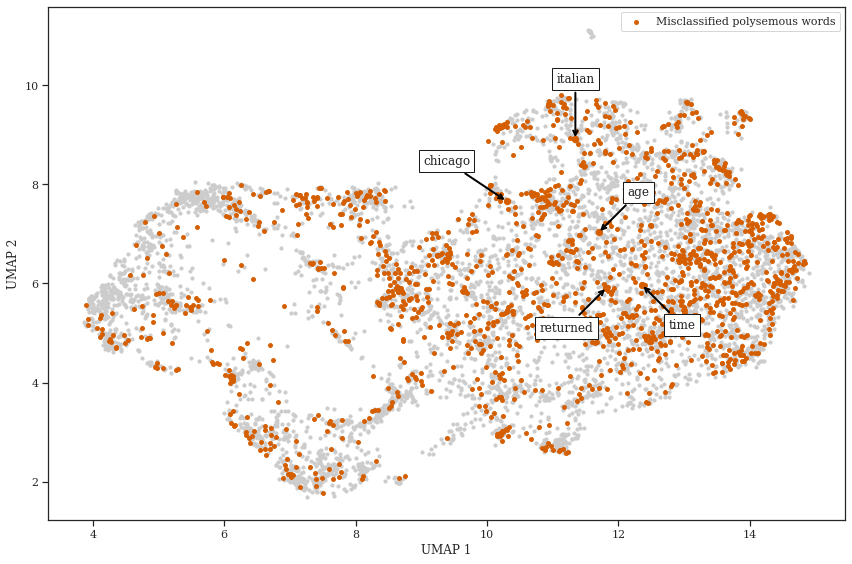

<IPython.core.display.Javascript object>

In [34]:
_, ax = plt.subplots(figsize=(12, 8))

# Countries and capitals
word_group_visualization(
    transformed_word_embeddings=word_meaning_test_data_word_umap_embedding,
    words=word_meaning_test_data["word"].values,
    word_groups={
        "misclassified_polysemous_words": {
            "words": misclassified_test_words,
            "color": "r",
            "label": "Misclassified polysemous words",
        },
    },
    emphasis_words=[
        ("time", 40, -80),
        ("age", 40, 0),
        ("returned", -40, -80),
        ("italian", 0, 20),
        ("chicago", -60, 0),
    ],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    alpha=1,
    ax=ax,
    scatter_set_rasterized=True,
    show_plot=False,
)
ax.legend()

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "bwme-enwiki-umap-misclassified-polysemous-words.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

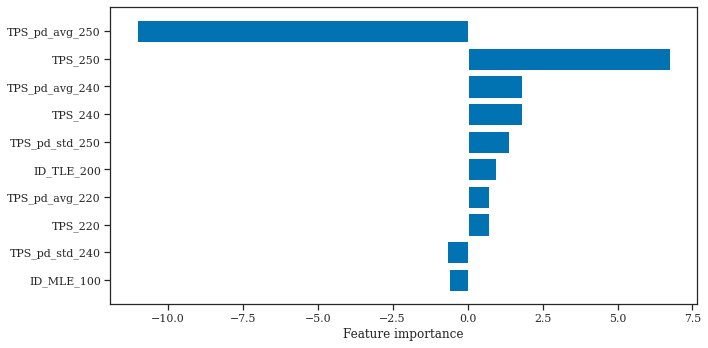

<IPython.core.display.Javascript object>

In [28]:
# Visualize top 10 feature importances
_, ax = plt.subplots(figsize=(10, 5))

# Sort coefficient by absolute value
binary_log_reg_coef_abs_sorted_indces = np.argsort(abs(binary_logistic_reg.coef_[0]))[
    ::-1
]
top_n_importances = 10
top_n_importances_indices = binary_log_reg_coef_abs_sorted_indces[:top_n_importances]

# Plot horizontal barplot
y_pos = np.arange(top_n_importances)
ax.barh(
    y=y_pos, width=binary_logistic_reg.coef_[0][top_n_importances_indices], color="b"
)
ax.set_yticks(y_pos)
ax.set_yticklabels(
    word_meaning_data_feature_cols_human_readable[top_n_importances_indices]
)
ax.invert_yaxis()
ax.set_xlabel("Feature importance")

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "bwme-enwiki-top-10-feature-importances.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

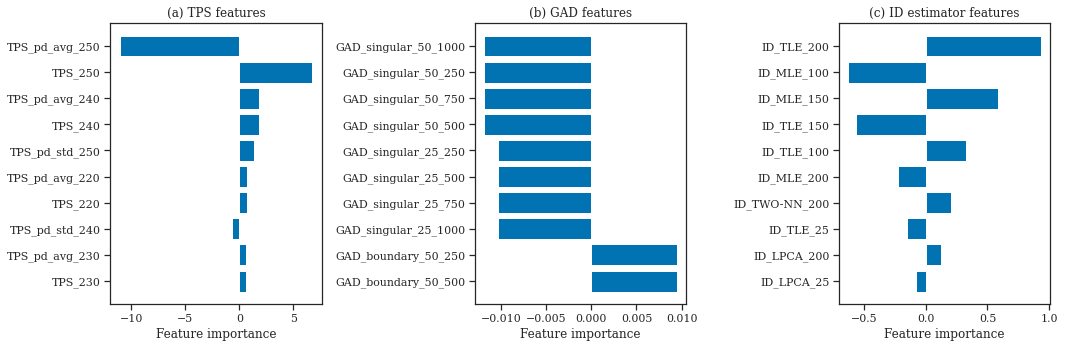

<IPython.core.display.Javascript object>

In [29]:
# Visualize top 10 feature importances
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax_chars = "abc"

top_n_importances = 10
feature_alg_names = ["TPS", "GAD", "ID estimator"]
feature_alg_names_start = ["X_tps", "X_gad", "X_estimated_id"]
for ax, ax_char, alg_name, alg_names_start in zip(
    axes, ax_chars, feature_alg_names, feature_alg_names_start
):
    # Filter algorithm columns
    alg_filter = [
        i
        for i, feature_col in enumerate(word_meaning_data_feature_cols)
        if feature_col.startswith(alg_names_start)
    ]
    alg_coeffs = binary_logistic_reg.coef_[0][alg_filter]

    # Sort coefficient by absolute value
    binary_log_reg_coef_abs_sorted_indces = np.argsort(abs(alg_coeffs))[::-1]
    top_n_importances_indices = binary_log_reg_coef_abs_sorted_indces[
        :top_n_importances
    ]

    # Plot horizontal barplot
    y_pos = np.arange(top_n_importances)
    ax.barh(y=y_pos, width=alg_coeffs[top_n_importances_indices], color="b")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(
        word_meaning_data_feature_cols_human_readable[alg_filter][
            top_n_importances_indices
        ]
    )
    ax.invert_yaxis()
    ax.set_xlabel("Feature importance")
    ax.set_title(f"({ax_char}) {alg_name} features")

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "bwme-enwiki-top-10-feature-importances-tps-gad-estimated-ids.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

In [30]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=np.abs(binary_logistic_reg.coef_[0]),
    )
)

,feature,importance
0,X_tps_250_pd_avg,11.025471603568517
1,X_tps_250,6.757197813138055
2,X_tps_240_pd_avg,1.8112055184665496
3,X_tps_240,1.8112055184652214
4,X_tps_250_pd_std,1.383422090485649
5,X_estimated_id_tle_200,0.9316825666377543
6,X_tps_220_pd_avg,0.7263575315839577
7,X_tps_220,0.7263575315835183
8,X_tps_240_pd_std,0.6862964340758861
9,X_estimated_id_mle_100,0.62634416237688


<IPython.core.display.Javascript object>

In [31]:
print(f"Number of zero features: {sum(binary_logistic_reg.coef_[0] == 0)}")

Number of zero features: 0


<IPython.core.display.Javascript object>